# Project 3a

The final part of the project will ask you to perform your own data science project to classify a new dataset.

## Submission Details

**Project is due June 14th at 11:59 pm (Friday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend printing the notebook using [$\LaTeX$](https://www.latex-project.org/)**

## Loading Essentials and Helper Functions 

In [1]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [2]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

## Background: Dataset Information (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (male/female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [3]:
# Preprocess Data

# Load Data
data = pd.read_csv("datasets/heartdisease.csv")

# Transform target feature into numerical
le = LabelEncoder()
data["target"] = le.fit_transform(data["sick"])
data["sex"] = le.fit_transform(data["sex"])
data = data.drop(["sick"], axis=1)

# Split target and data
y = data["target"]
x = data.drop(["target"], axis=1)

# Train test split
# 40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(
    x, y, test_size=0.4, stratify=y, random_state=0
)

# Feature Transformation
# This is the only change from project 2 since we replaced standard scaler to minmax
# This was done to ensure that the numerical features were still of the same scale
# as the one hot encoded features
num_pipeline = Pipeline([("minmax", MinMaxScaler())])

heart_num = train_raw.drop(
    ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"], axis=1
)
numerical_features = list(heart_num)
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories="auto"), categorical_features),
    ]
)

# Transform raw data|
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)  # Note that there is no fit calls

# Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [4]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [5]:
# Baseline accuracy of using the majority class
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
target
0    66
1    56
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.541


## 1. (25 pts) Decision Trees

### 1.1. [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use `random_state = SEED` so that your results match ours.

Accuracy: 71.311%


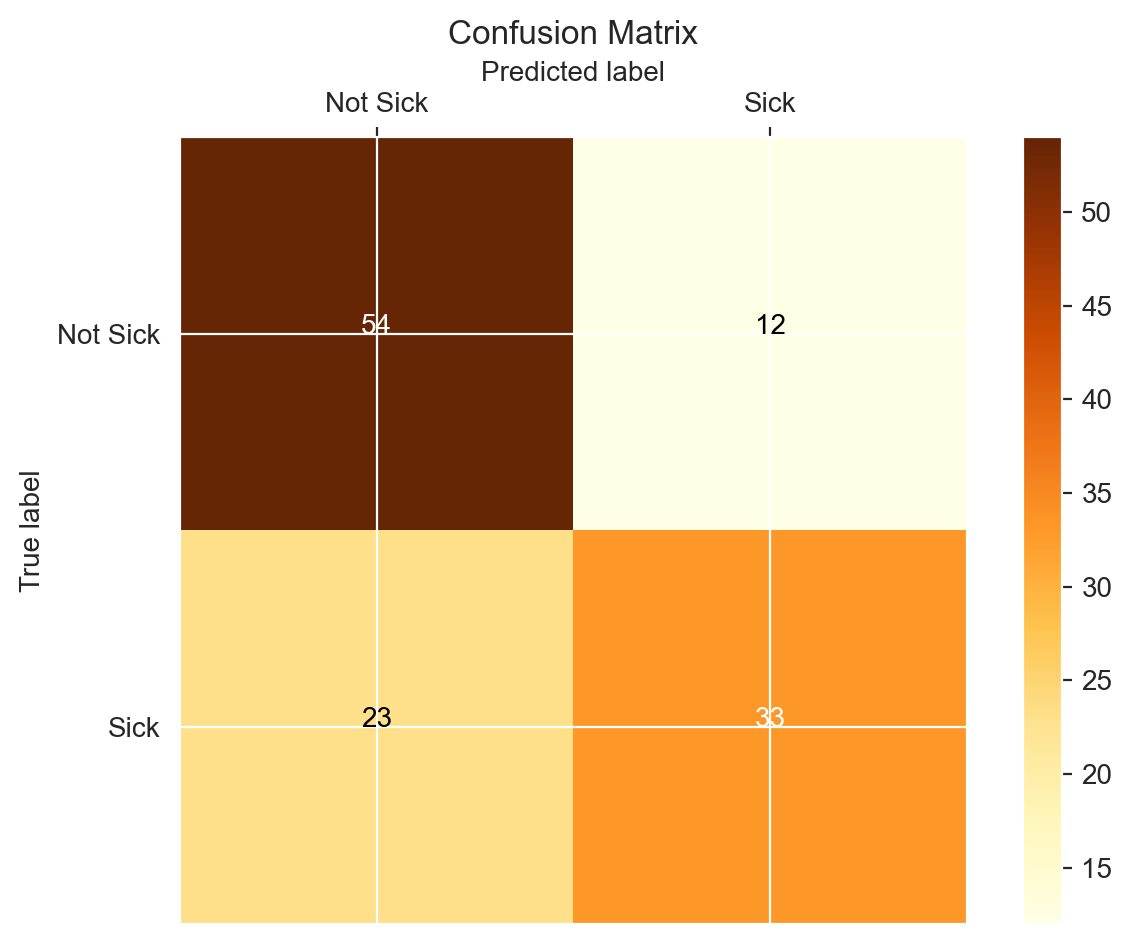

In [6]:
# Create a decision tree classifier
dt = DecisionTreeClassifier(random_state=SEED)
# Train the classifier
dt.fit(train, target)
# Predict on the test data
y_pred = dt.predict(test)
# Calculate the accuracy score
accuracy = metrics.accuracy_score(target_test, y_pred)
# Print the accuracy score
print(f"Accuracy: {accuracy * 100:.3f}%")
draw_confusion_matrix(target_test, y_pred, ['Not Sick', 'Sick'])

### 1.2. [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

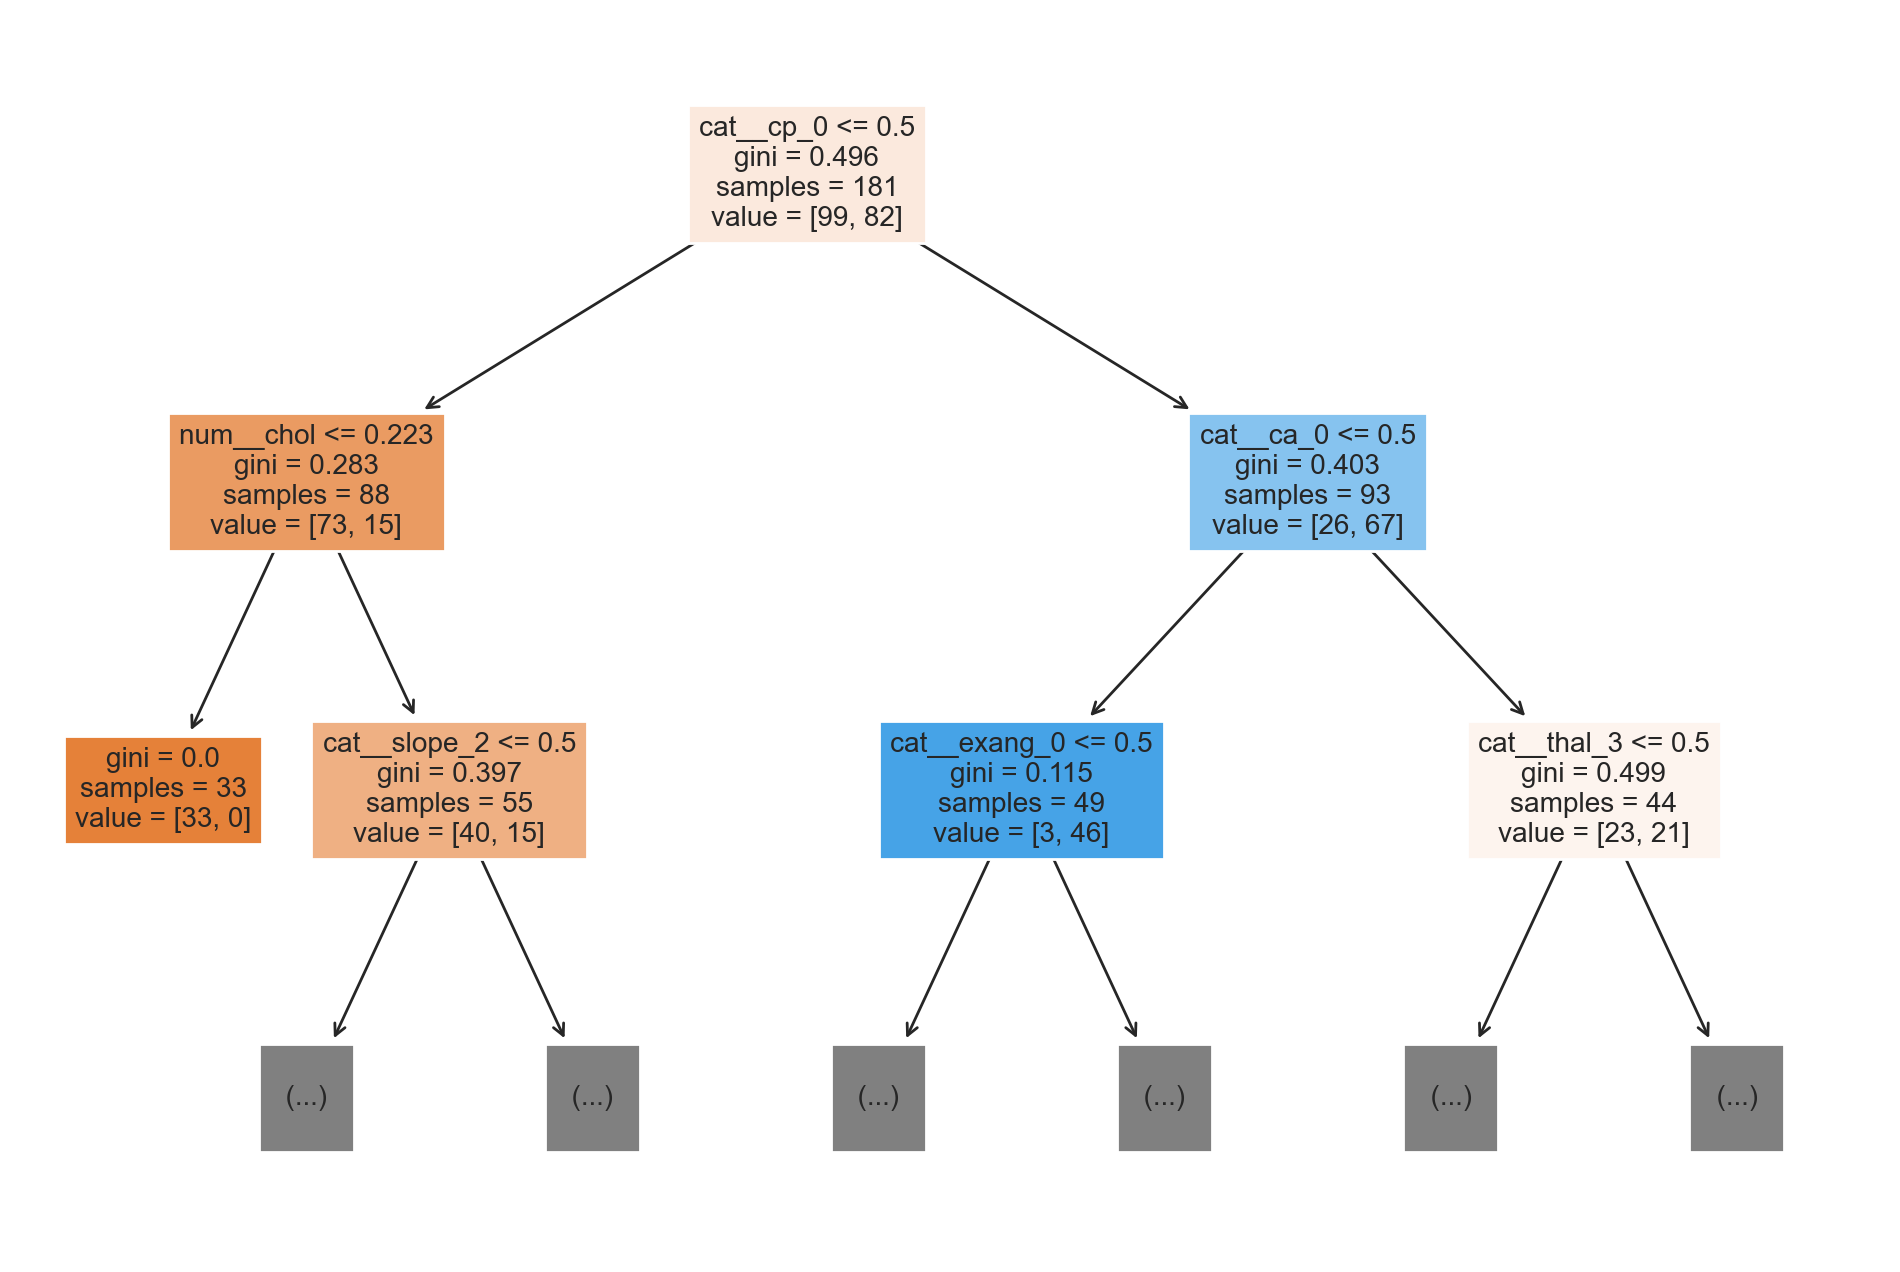

In [7]:
# Visualizing first two layers of decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(dt, max_depth=2, feature_names=list(feature_names), filled=True)
plt.show()

**What is the gini index improvement of the first split?**

In [8]:
N = 181
n1 = 88
n2 = 93
Gini_parent = 0.496
Gini_left = 0.283
Gini_right = 0.403

Gini_decrease = Gini_parent - (n1 / N) * Gini_left - (n2 / N) * Gini_right
print("Gini decrease: ", Gini_decrease)


Gini decrease:  0.15134254143646406


Response: The gini index improvement of the first split is 0.151

### 1.3 [5 pts] Plot the importance of each feature for the Decision Tree

<Axes: >

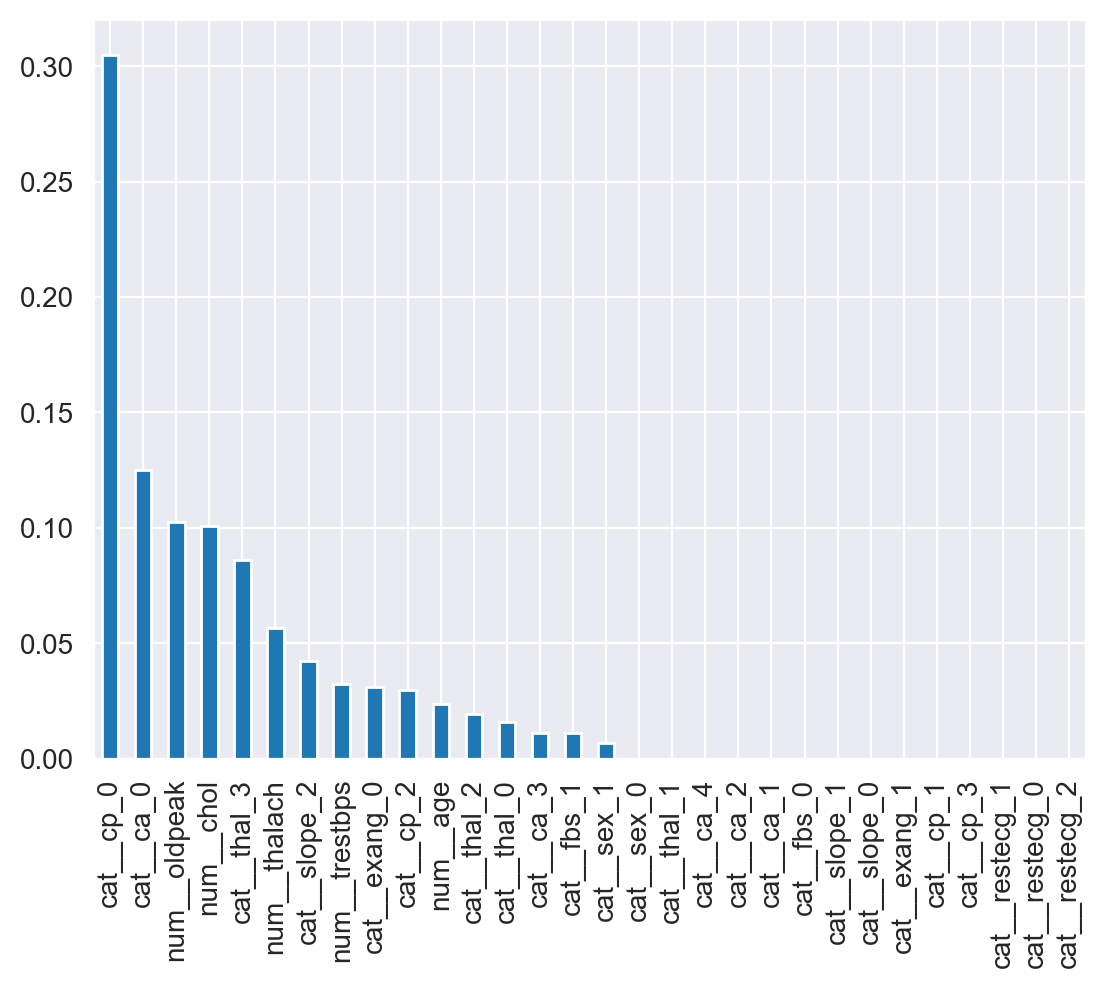

In [9]:
# Plotting importance of each feature for DT
imp_pd = pd.Series(data=dt.feature_importances_, index=feature_names)
imp_pd = imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: There are 16 features with non-zero importance. If we remove the features with zero important, it will not change the decision tree for the same sampled dataset since they don't add anything to the model.

### 1.4 [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a `GridSearchCV` with 5-Fold Cross Validation for the Decision Tree. Find the best model parameters for accuracy amongst the following:

- `max_depth` = [2, 4, 8, 16, 32]
- `min_samples_split` = [2, 4, 8, 16]
- `criterion` = [`gini`, `entropy`]

After using `GridSearchCV`, Print the **best 5 models** with the following parameters: `rank_test_score`, `param_max_depth`, `param_min_samples_split`, `param_criterion`, `mean_test_score`, `std_test_score`.


In [10]:
# running grid search
param_grid = {
    "max_depth": [2, 4, 8, 16, 32],
    "min_samples_split": [2, 4, 8, 16],
    "criterion": ['gini', 'entropy']
}

# Initialize grid search
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit data
grid_search.fit(train, target)

# Get results
grid_search_results = grid_search.cv_results_

# Make dataframe with results
grid_search_df = pd.DataFrame(grid_search_results)

# Sorting by rank_test_score
grid_search_df = grid_search_df.sort_values(by='rank_test_score')

# Printing specified columns
print(grid_search_df.head(5)[['rank_test_score', 'param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_test_score', 'std_test_score']])

    rank_test_score param_max_depth param_min_samples_split param_criterion  \
5                 1               4                       4            gini   
16                2              32                       2            gini   
12                2              16                       2            gini   
4                 4               4                       2            gini   
17                5              32                       4            gini   

    mean_test_score  std_test_score  
5          0.745796        0.071303  
16         0.740841        0.095233  
12         0.740841        0.095233  
4          0.740541        0.066108  
17         0.740390        0.081398  


**Using the best model you have, report the test accuracy and print out the confusion matrix**

Accuracy: 70.492%


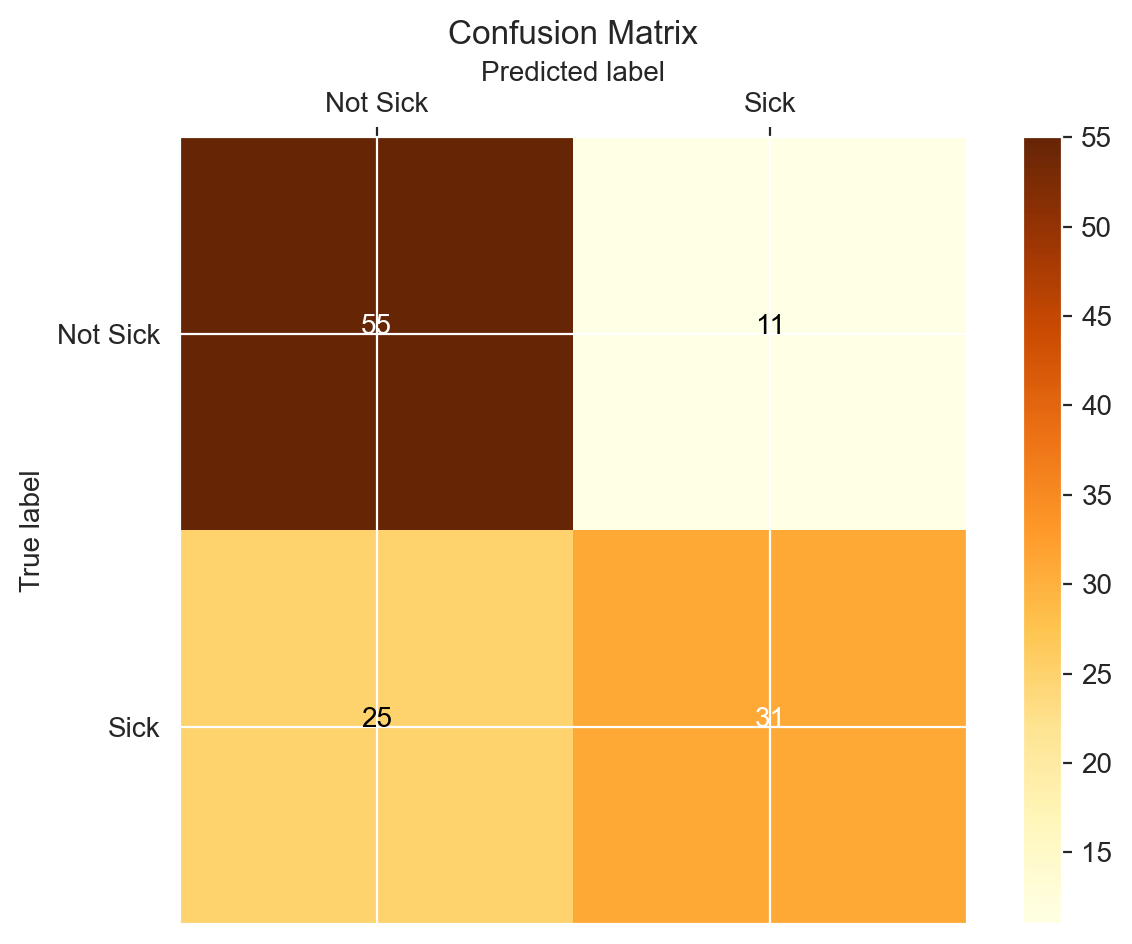

In [11]:
# Initialize best model
best_dt = grid_search.best_estimator_

# Make predictions
predictions = best_dt.predict(test)

# Calculate accuracy
accuracy = metrics.accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy*100:.3f}%")

# Printing confusion matrix
draw_confusion_matrix(target_test, predictions, ['Not Sick', 'Sick'])


## 2. (20 pts) Multi-Layer Perceptron

### 2.1 [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(50, 50) and max_iter = 1000. **Report the accuracy and print the confusion matrix**. Make sure to set `random_state=SEED`. 

MLP Accuracy: 81.967%


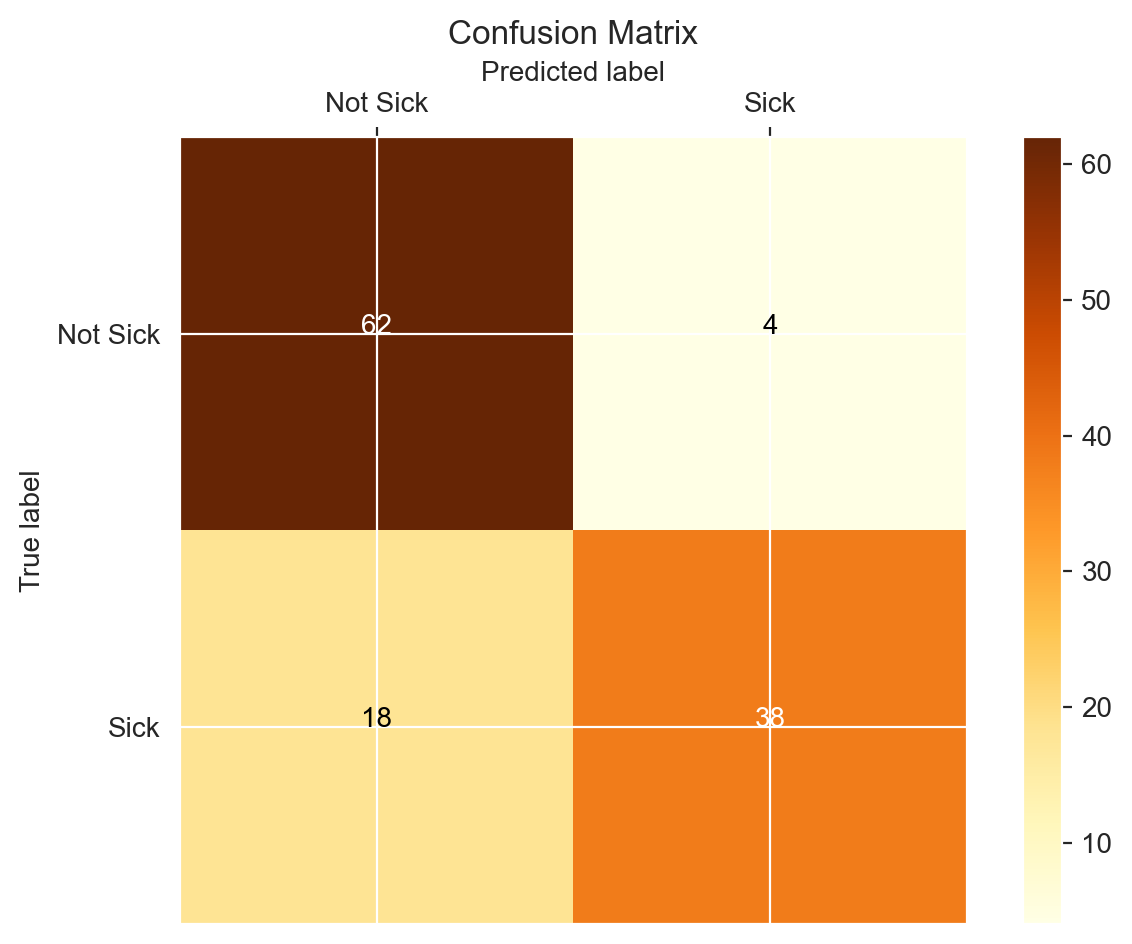

In [12]:
# Building neural network
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=SEED)
mlp.fit(train, target)
mlp_predictions = mlp.predict(test)
mlp_accuracy = metrics.accuracy_score(target_test, mlp_predictions)
print(f"MLP Accuracy: {mlp_accuracy*100:.3f}%")

# Drawing confusion matrix
draw_confusion_matrix(target_test, mlp_predictions, ['Not Sick', 'Sick'])

### 2.2 [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [13]:
# Getting time for Decision trees
dt_model = DecisionTreeClassifier()

# Train
start_time = time.time()
dt_model.fit(train, target)
end_time = time.time()
dt_fit_time = end_time - start_time
print(f"Training for Decision Tree took {dt_fit_time:.3f} seconds")

# Predictions
start_time = time.time()
dt_predictions = dt_model.predict(test)
end_time = time.time()
dt_predict_time = end_time - start_time
print(f"Prediction for Decision Tree took {dt_predict_time:.3f} seconds")

# Now timing MLPs
mlp = MLPClassifier()

# Train
start_time = time.time()
mlp.fit(train, target)
end_time = time.time()
mlp_fit_time = end_time - start_time
print(f"\nTraining for MLP took {mlp_fit_time:.3f} seconds")
# Predictions
start_time = time.time()
mlp_predictions = mlp.predict(test)
end_time = time.time()
mlp_predict_time = end_time - start_time
print(f"Prediction for MLP took {mlp_predict_time:.3f} seconds\n")

if dt_fit_time < mlp_fit_time:
    print("Decision tree was faster for training")
else:
    print("MLP was faster for training")
    
if dt_predict_time < mlp_predict_time:
    print("Decision tree was faster for predicting")
else:
    print("MLP was faster for prediction")

Training for Decision Tree took 0.003 seconds
Prediction for Decision Tree took 0.000 seconds

Training for MLP took 0.607 seconds
Prediction for MLP took 0.001 seconds

Decision tree was faster for training
Decision tree was faster for predicting


/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Decision Trees were much quicker than the MLP.

### 2.3 [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response:

__Advantages:__
* MLPs can model highly complex non-linear patterns that decision trees may not be able to grasp with the same level of depth
* Known to perform better with high dimensional data or when there are a lot of input features

__Disadvantages:__
* Decision trees are more interpretable than MLPs since they mirror human decision-making more closely.
* MLPs are much more computationally intensive and require more training time due to the weighting and biases through backpropagation
* MLPs can easily overfit if parameters are not properly tuned

## 3 (35 pts) PCA

### 3.1 [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [14]:
# Training PCA model to get top 10 components
pca = PCA(n_components=10)

# Fit
pca.fit(train)

# Print components
components = pd.DataFrame(pca.components_, columns=feature_names, index=[f"PC{i+1}" for i in range(10)])
print(components)

      num__age  num__trestbps  num__chol  num__thalach  num__oldpeak  \
PC1   0.060995       0.040349   0.019246     -0.101732      0.110715   
PC2   0.052318       0.028903   0.038265     -0.007332     -0.003729   
PC3  -0.042762      -0.037421   0.003541     -0.047336      0.018013   
PC4  -0.010853       0.051289   0.020437      0.046852      0.032077   
PC5   0.046279       0.019704  -0.003820     -0.035099      0.002135   
PC6  -0.068368      -0.021063  -0.036407      0.005768     -0.043766   
PC7  -0.017813       0.073087   0.020167      0.018262      0.028365   
PC8   0.043352       0.054215  -0.034704     -0.015333      0.018508   
PC9  -0.059761      -0.036937   0.006613      0.056159     -0.048061   
PC10 -0.039564       0.014499  -0.001864      0.073457      0.096446   

      cat__sex_0  cat__sex_1  cat__cp_0  cat__cp_1  cat__cp_2  ...  \
PC1    -0.123314    0.123314   0.342653  -0.134589  -0.209361  ...   
PC2     0.444422   -0.444422   0.073622  -0.031715  -0.028608  ... 

### 3.2 [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [15]:
# Calculating the explained variance
explained_variance_ratio = pca.explained_variance_ratio_

for i, explained_variance in enumerate(explained_variance_ratio, 1):
    print(f"Principal component {i}: {explained_variance*100:.3f}% of the variance")

Principal component 1: 23.862% of the variance
Principal component 2: 13.604% of the variance
Principal component 3: 10.034% of the variance
Principal component 4: 8.239% of the variance
Principal component 5: 7.495% of the variance
Principal component 6: 6.591% of the variance
Principal component 7: 5.919% of the variance
Principal component 8: 4.936% of the variance
Principal component 9: 4.041% of the variance
Principal component 10: 2.994% of the variance


### 3.3 [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [16]:
# Transforming the train and test data
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

### 3.4 [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy with PCA: 81.148%


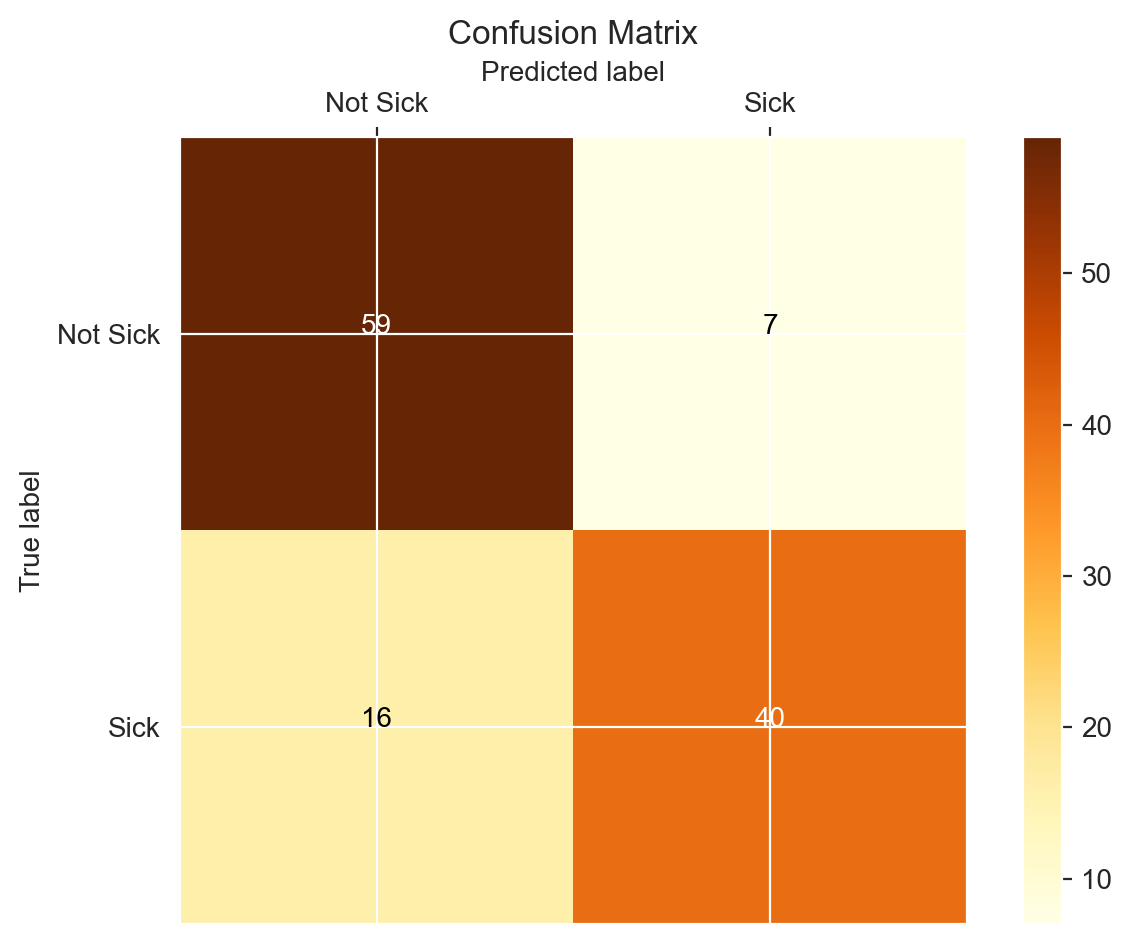

In [17]:
# Training default DTC using train_pca
dt_pca = DecisionTreeClassifier(random_state=SEED)
dt_pca.fit(train_pca, target)

# Predict on the test data using the trained PCA model
y_pred_pca = dt_pca.predict(test_pca)

# Calculate the accuracy score
accuracy_pca = metrics.accuracy_score(target_test, y_pred_pca)
# Print the accuracy score
print(f"Accuracy with PCA: {accuracy_pca * 100:.3f}%")

# Drawing confusion matrix
draw_confusion_matrix(target_test, y_pred_pca, ['Not Sick', 'Sick'])

**Does the model perform better with or without PCA?**

Response: The model performs much better with the PCA, about 11% better

### 3.5 [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

MLP Accuracy: 80.328%


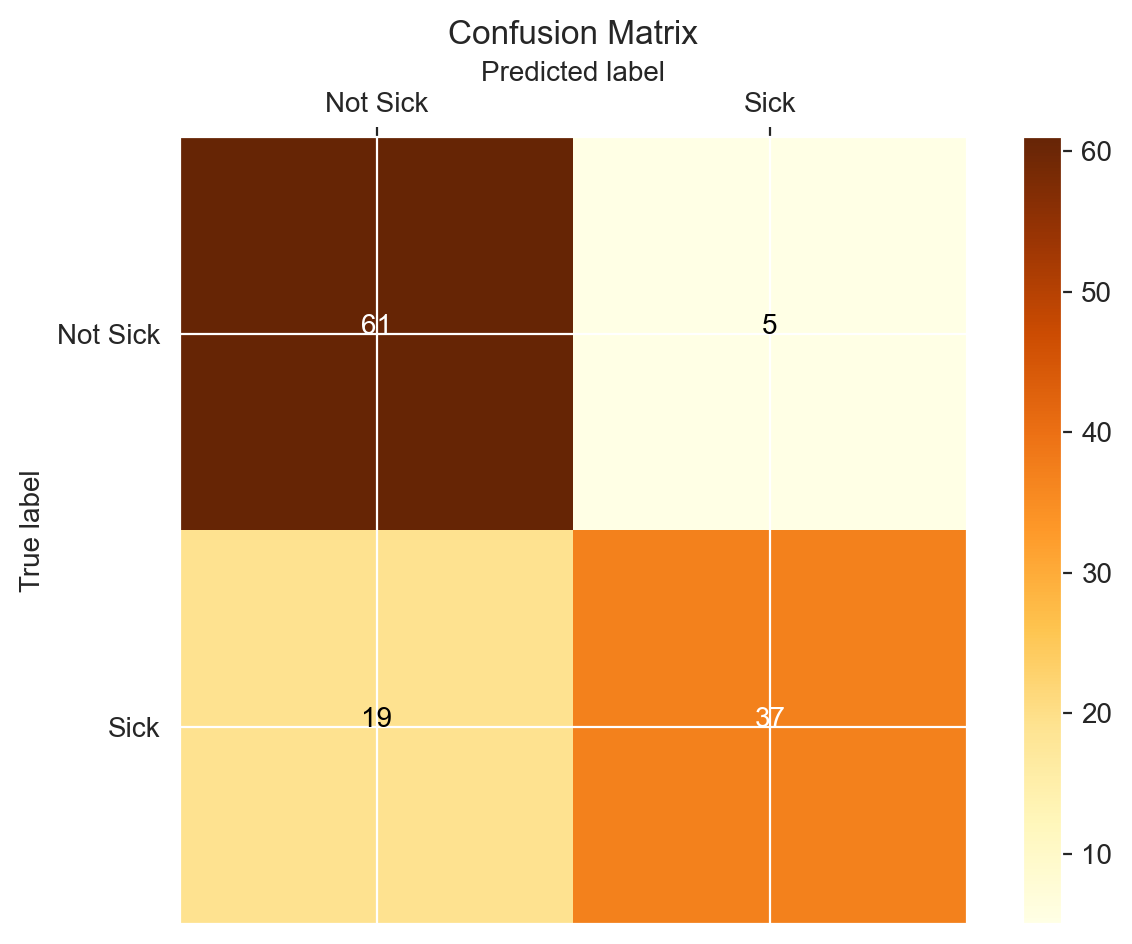

In [18]:
# Training MLP with train_pca
mlp_pca = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=SEED)
mlp_pca.fit(train_pca, target)
mlp_pca_predictions = mlp_pca.predict(test_pca)
mlp_pca_accuracy = metrics.accuracy_score(target_test, mlp_pca_predictions)
print(f"MLP Accuracy: {mlp_pca_accuracy*100:.3f}%")

# Drawing confusion matrix
draw_confusion_matrix(target_test, mlp_pca_predictions, ['Not Sick', 'Sick'])

**Does the model perform better with or without PCA?**

Response: It performs a little worse than the model without PCA. This is probably because MLPs perform very well on high dimensional data, which PCA reduces and thus reduces accuracy.

### 3.6 [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response:

__Pros:__
* Dimensionality reduction can help for identifying the most significant features (used in feature engineering) and can simplify complex data analysis or is used in pre-processing steps
* Can help reduce noise by keeping only the most significant features

__Cons:__
* Data must be linearly related since PCA assumes the principal components are a linear combination of the original features. If this is not the case, PCA won't produce meaningful results
* Lack of interpretability is a big issue with PCA, since it creates a new set of features that are vectors essentially. These aren't really readable

## 4. (20 pts) K-Means Clustering

### 4.1 [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and `random_state = SEED`.

In [19]:
# Building k-means model
kmeans = KMeans(n_clusters=5, random_state=SEED)
kmeans.fit(train)

# Printing intertia score
print(f"Inertia: {kmeans.inertia_}")

/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia: 481.6305513703053


### 4.2 [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 25. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use `random_state = SEED`.

/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412:

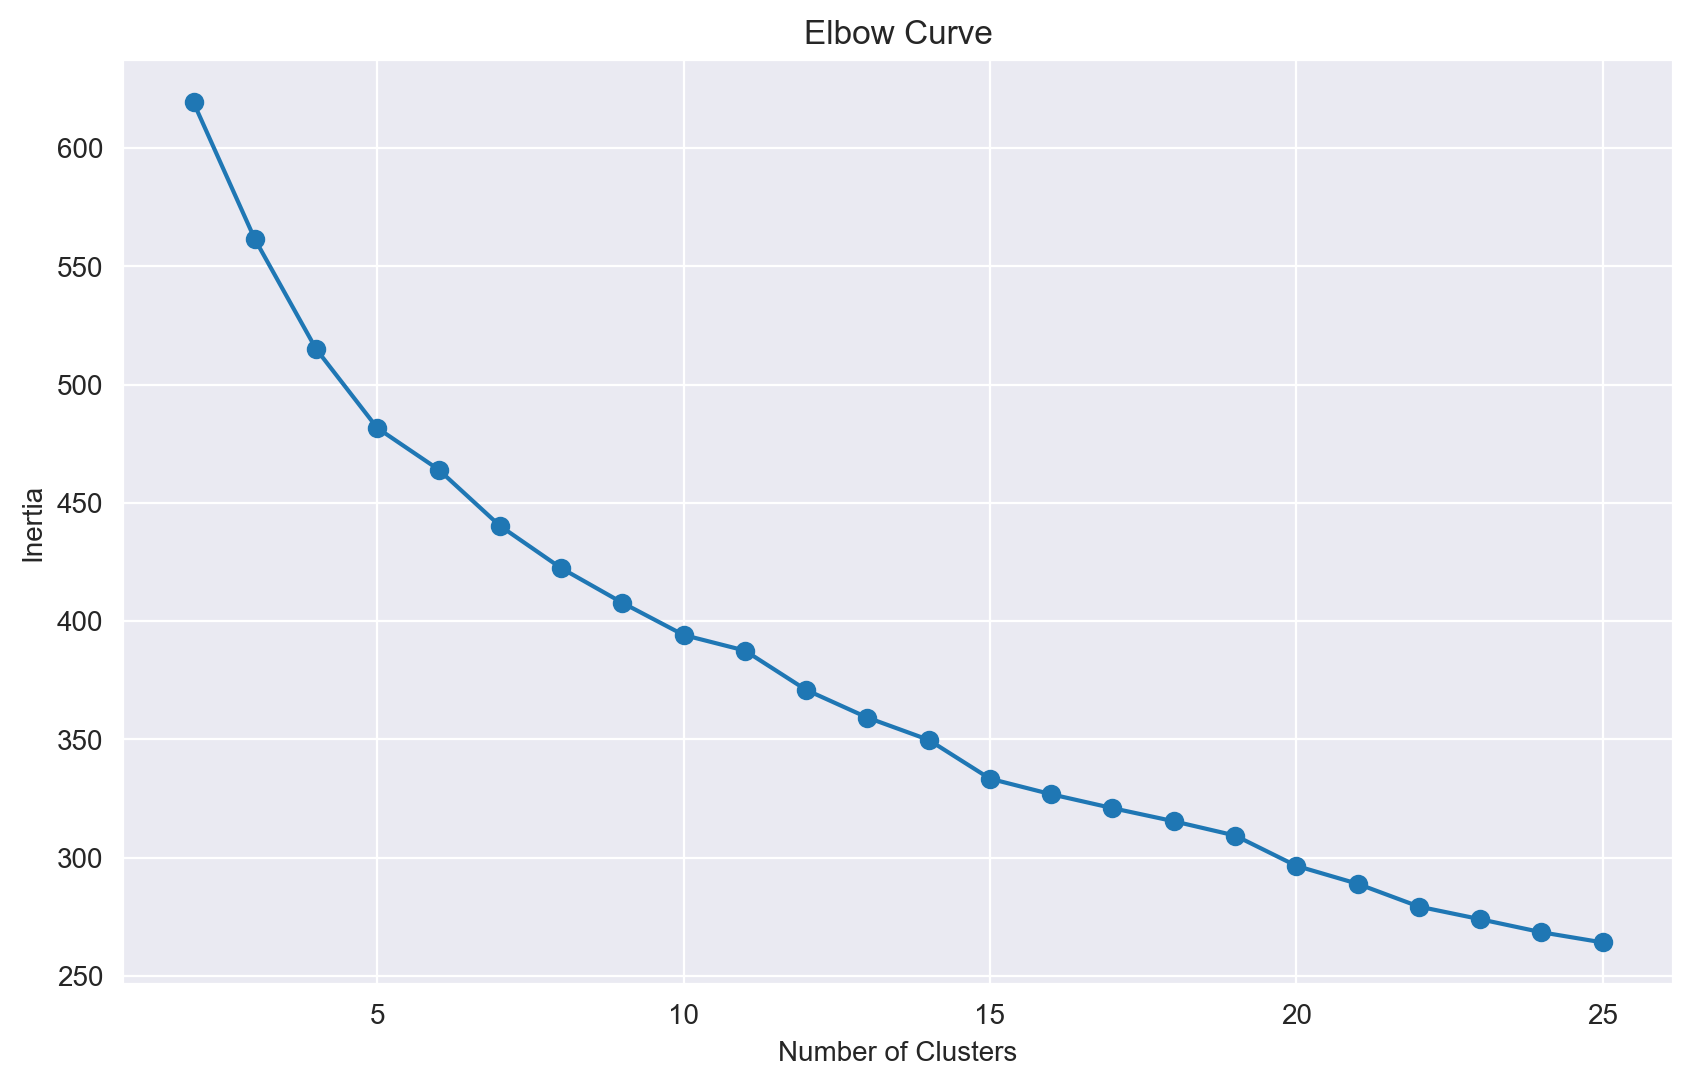

In [20]:
# Finding optimal cluster size
inertia = []

# Define cluster range
clusters = list(range(2, 26))

# Run kmeans for each number
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=SEED)
    kmeans.fit(train)
    inertia.append(kmeans.inertia_)
    
# Plotting elbow curve
plt.figure(figsize=(10,6))
plt.plot(clusters, inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

From the plot, we can guess that the best cluster size is somewhere between 5 and 10.

### 4.3 [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [21]:
# Using train_pca instead
# Building k-means model
kmeans = KMeans(n_clusters=5, random_state=SEED)
kmeans.fit(train_pca)

# Printing intertia score
print(f"Inertia: {kmeans.inertia_}")

Inertia: 395.92442201374405


/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aidancone/anaconda3/envs/ece148/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412:

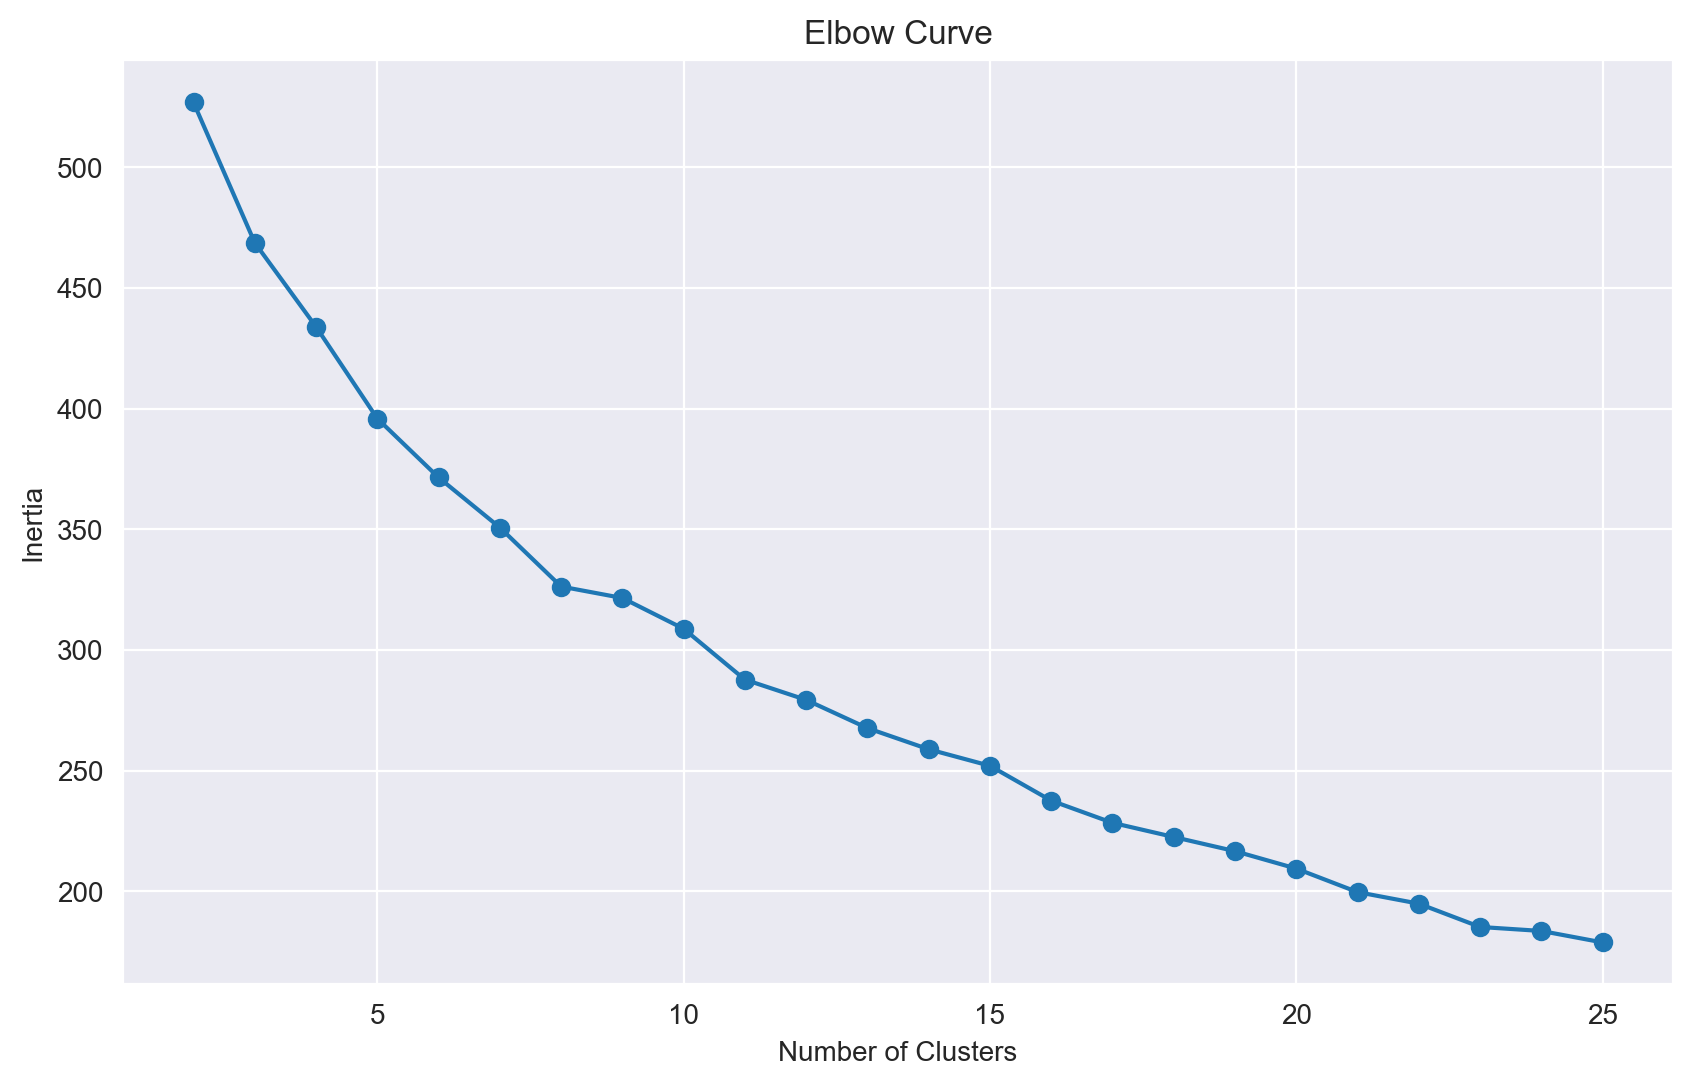

In [22]:
# Finding optimal cluster size
inertia = []

# Define cluster range
clusters = list(range(2, 26))

# Run kmeans for each number
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=SEED)
    kmeans.fit(train_pca)
    inertia.append(kmeans.inertia_)

# Plotting elbow curve
plt.figure(figsize=(10,6))
plt.plot(clusters, inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

Similar to the previous experiment, we can guess that the best cluster size is somewhere between 5 and 10. Additionally, we see that the inertia is much smaller for every cluster size when using PCA features.

Response: The best cluster size here looks to be around 7, based on the kink in the graph.